Using GPU: NVIDIA GeForce RTX 4070 with CUDA version 12.4
Epoch [1/10], Batch [100/1076]
Epoch [1/10], Batch [200/1076]
Epoch [1/10], Batch [300/1076]
Epoch [1/10], Batch [400/1076]
Epoch [1/10], Batch [500/1076]
Epoch [1/10], Batch [600/1076]
Epoch [1/10], Batch [700/1076]
Epoch [1/10], Batch [800/1076]
Epoch [1/10], Batch [900/1076]
Epoch [1/10], Batch [1000/1076]
Epoch [1/10], Train Loss: 0.8023, Test Loss: 0.6562, Test Accuracy: 77.14%
Epoch [2/10], Batch [100/1076]
Epoch [2/10], Batch [200/1076]
Epoch [2/10], Batch [300/1076]
Epoch [2/10], Batch [400/1076]
Epoch [2/10], Batch [500/1076]
Epoch [2/10], Batch [600/1076]
Epoch [2/10], Batch [700/1076]
Epoch [2/10], Batch [800/1076]
Epoch [2/10], Batch [900/1076]
Epoch [2/10], Batch [1000/1076]
Epoch [2/10], Train Loss: 0.6265, Test Loss: 0.5961, Test Accuracy: 81.67%
Epoch [3/10], Batch [100/1076]
Epoch [3/10], Batch [200/1076]
Epoch [3/10], Batch [300/1076]
Epoch [3/10], Batch [400/1076]
Epoch [3/10], Batch [500/1076]
Epoch [3/10], B

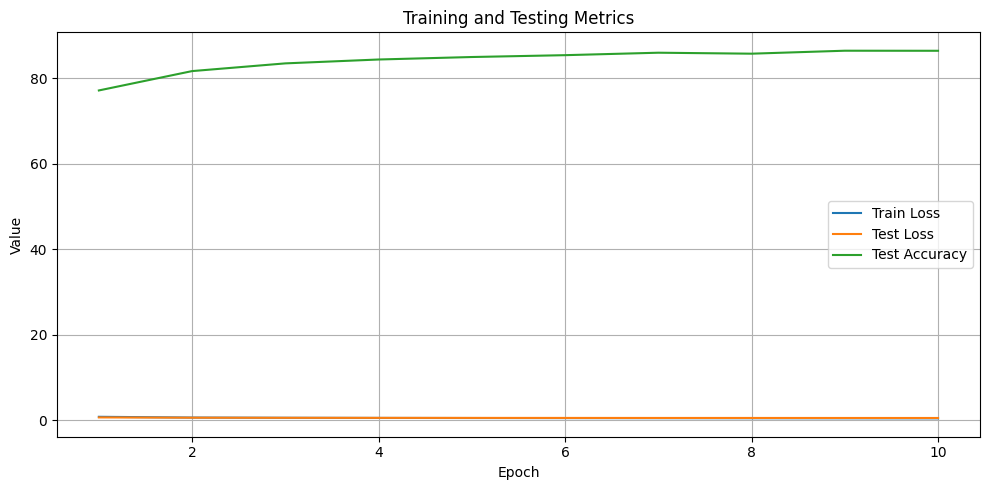

Real image "eyes_FUF7JYKP_Up.jpg" in class "Up" predicted as "Up".
Real image "eyes_PHSGOYCT_Down.jpg" in class "Down" predicted as "Down".
Real image "eyes_707QB2RP_Center.jpg" in class "Center" predicted as "Up".
Evaluation on real images complete.


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms, models
from torchvision.models import AlexNet_Weights  # Import weights enum
import onnx
import onnxruntime as ort
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageFilter
import numpy as np
from torch.amp import GradScaler, autocast
import random

# Define paths
base_dir = '/mnt/c/Users/rober/Desktop/GazeDetectionStudy'
dataset_dir = os.path.join(base_dir, 'dataset')  # Synthetic dataset
natural_dataset_dir = os.path.join(base_dir, 'natural_dataset')  # Real images
model_save_dir = os.path.join(base_dir, 'models', 'mixed_alexnet')  # Changed to 'mixed_alexnet'
os.makedirs(model_save_dir, exist_ok=True)

# Parameters
batch_size = 128
num_epochs = 10
learning_rate = 0.000001
num_classes = 3

# Data transforms for the synthetic dataset ('dataset')
synthetic_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 2)))),
    transforms.Lambda(lambda img: img.resize((random.randint(100, 224), random.randint(100, 224)), Image.BILINEAR).resize((224, 224), Image.BILINEAR)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization
                         std=[0.229, 0.224, 0.225])
])

# Data transforms for the natural dataset ('natural_dataset')
natural_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=5),
    transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 1)))),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization
                         std=[0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
# Synthetic dataset
synthetic_train_dataset = datasets.ImageFolder(os.path.join(dataset_dir, 'train'), transform=synthetic_transforms)
synthetic_test_dataset = datasets.ImageFolder(os.path.join(dataset_dir, 'test'), transform=synthetic_transforms)

# Natural dataset
natural_train_dataset = datasets.ImageFolder(os.path.join(natural_dataset_dir, 'train'), transform=natural_transforms)
natural_test_dataset = datasets.ImageFolder(os.path.join(natural_dataset_dir, 'test'), transform=natural_transforms)

# Augment the natural dataset by 100x
natural_train_dataset.samples = natural_train_dataset.samples * 100
natural_test_dataset.samples = natural_test_dataset.samples * 100

# Combine synthetic and natural datasets
train_dataset = ConcatDataset([synthetic_train_dataset, natural_train_dataset])
test_dataset = ConcatDataset([synthetic_test_dataset, natural_test_dataset])

# DataLoaders
num_workers = min(8, os.cpu_count())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

# Load pre-trained AlexNet model with updated weights parameter
model = models.alexnet(weights=AlexNet_Weights.DEFAULT)

# Modify the classifier to match the number of classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optionally, freeze some layers (here we train the whole model)
# If you want to freeze the feature extractor, uncomment the following lines
# for param in model.features.parameters():
#     param.requires_grad = False

# Print CUDA device information
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)} with CUDA version {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU for training.")

# Enable CuDNN benchmarking for performance optimization
torch.backends.cudnn.benchmark = True

# Loss and optimizer with label smoothing and weight decay
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scaler = GradScaler()  # Updated GradScaler initialization

# Training loop
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast(device_type=device.type):  # Updated autocast context
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}]")

    train_losses.append(running_loss / len(train_loader))

    # Evaluation on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            with autocast(device_type=device.type):  # Updated autocast context
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

# Save the model
pth_model_path = os.path.join(model_save_dir, 'mixed_alexnet_gaze.pth')
torch.save(model.state_dict(), pth_model_path)
print(f'Model saved to {pth_model_path}')

# Export to ONNX
onnx_model_path = os.path.join(model_save_dir, 'mixed_alexnet_gaze.onnx')
dummy_input = torch.randn(1, 3, 224, 224, device=device)
torch.onnx.export(
    model, dummy_input, onnx_model_path,
    input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=14
)
print(f'Model exported to ONNX format at {onnx_model_path}')

# Verify ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

# Training Visualization
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Test Accuracy': test_accuracies
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='Train Loss', data=df, label='Train Loss')
sns.lineplot(x='Epoch', y='Test Loss', data=df, label='Test Loss')
sns.lineplot(x='Epoch', y='Test Accuracy', data=df, label='Test Accuracy')
plt.title('Training and Testing Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate on real images from 'natural_dataset'
class_names = ['Up', 'Down', 'Center']
model.eval()

for cls in class_names:
    image_path = os.path.join(natural_dataset_dir, 'test', cls)
    if os.path.exists(image_path):
        image_files = os.listdir(image_path)
        if image_files:
            image_file = random.choice(image_files)
            full_image_path = os.path.join(image_path, image_file)
            image = Image.open(full_image_path).convert('RGB')
            image = natural_transforms(image).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(image)
                _, predicted = torch.max(output, 1)
                predicted_class = class_names[predicted.item()]

            print(f'Real image "{image_file}" in class "{cls}" predicted as "{predicted_class}".')

print("Evaluation on real images complete.")
